In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
table_scan_data = pd.read_csv("data/data/train/TableScan.csv")
table_data = pd.read_csv("data/data/train/table_meta.csv")
columns_data = pd.read_csv("data/data/train/column_meta.csv")
chunk_meta = pd.read_csv("data/data/train/segment_meta.csv")

joined_data = table_scan_data.merge(table_data, on=["TABLE_NAME"], how="left")
joined_data = joined_data.merge(columns_data, on=["TABLE_NAME", "COLUMN_NAME"], how="left")

# only look at the encoding of the first chunk
chunkrows = chunk_meta.loc[(chunk_meta['CHUNK_ID'] == 0)]
joined_data = joined_data.merge(chunkrows, on=["TABLE_NAME", "COLUMN_NAME"], how="left")

joined_data = joined_data.rename(columns={"INPUT_ROWS_LEFT": "INPUT_ROWS", "CHUNK_SIZE": "MAX_CHUNK_SIZE",
                                          "COLUMN_DATA_TYPE": "DATA_TYPE", "ENCODING_TYPE": "ENCODING"})

# remove the rows with ExpressionEvaluator queries from the test data since we don't have any in the test data
joined_data = joined_data.loc[(joined_data['SCAN_IMPLEMENTATION'] != 'ExpressionEvaluator')]

# explicitly add selectivity
joined_data['SELECTIVITY'] = (joined_data['OUTPUT_ROWS'] / joined_data['INPUT_ROWS'])
joined_data['SELECTIVITY'].fillna(0, inplace=True)

In [3]:
joined_data.describe()

,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,ROW_COUNT,MAX_CHUNK_SIZE,CHUNK_ID,SELECTIVITY
count,17820.000000,17820.000000,1.782000e+04,17820.000000,17820.0,17820.0,17820.000000
mean,2532.315769,910.873457,1.935421e+06,3700.000000,1000.0,0.0,0.282904
std,3860.707648,2006.762136,3.022918e+06,4470.024751,0.0,0.0,0.321721
min,0.000000,0.000000,2.064100e+04,100.000000,1000.0,0.0,0.000000
25%,100.000000,0.000000,2.148235e+05,100.000000,1000.0,0.0,0.000000
50%,625.000000,44.000000,5.703760e+05,1000.000000,1000.0,0.0,0.153709
75%,2395.000000,523.000000,2.331004e+06,10000.000000,1000.0,0.0,0.496100
max,10000.000000,10000.000000,3.061090e+07,10000.000000,1000.0,0.0,1.000000


In [4]:
ohe_data = joined_data.drop(labels=['TABLE_NAME', 'COLUMN_NAME'], axis=1)
ohe_data = pd.get_dummies(ohe_data, columns=['SCAN_TYPE', 'DATA_TYPE', 'ENCODING'])
ohe_data.head()

,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,SCAN_IMPLEMENTATION,ROW_COUNT,MAX_CHUNK_SIZE,CHUNK_ID,COMPRESSION_TYPE,SELECTIVITY,SCAN_TYPE_COLUMN_SCAN,...,DATA_TYPE_float,DATA_TYPE_int,DATA_TYPE_long,DATA_TYPE_string,ENCODING_Dictionary,ENCODING_FixedStringDictionary,ENCODING_FrameOfReference,ENCODING_LZ4,ENCODING_RunLength,ENCODING_Unencoded
0,100,56,405372,ColumnVsColumn,100,1000,0,NaN,0.56,1,...,0,1,0,0,0,0,0,0,0,1
1,100,56,405372,ColumnVsColumn,100,1000,0,FixedSize1ByteAligned,0.56,1,...,0,1,0,0,1,0,0,0,0,0
2,100,52,315508,ColumnVsColumn,100,1000,0,NaN,0.52,1,...,0,1,0,0,0,0,0,0,1,0
3,100,52,315508,ColumnVsColumn,100,1000,0,FixedSize2ByteAligned,0.52,1,...,0,1,0,0,0,0,1,0,0,0
4,100,43,354643,ColumnVsColumn,100,1000,0,NaN,0.43,1,...,0,0,1,0,0,0,0,0,0,1


In [5]:
ohe_data.describe()

,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,ROW_COUNT,MAX_CHUNK_SIZE,CHUNK_ID,SELECTIVITY,SCAN_TYPE_COLUMN_SCAN,SCAN_TYPE_REFERENCE_SCAN,DATA_TYPE_double,DATA_TYPE_float,DATA_TYPE_int,DATA_TYPE_long,DATA_TYPE_string,ENCODING_Dictionary,ENCODING_FixedStringDictionary,ENCODING_FrameOfReference,ENCODING_LZ4,ENCODING_RunLength,ENCODING_Unencoded
count,17820.000000,17820.000000,1.782000e+04,17820.000000,17820.0,17820.0,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000,17820.000000
mean,2532.315769,910.873457,1.935421e+06,3700.000000,1000.0,0.0,0.282904,0.555556,0.444444,0.183165,0.183165,0.225253,0.183165,0.225253,0.228956,0.045791,0.045791,0.221549,0.228956,0.228956
std,3860.707648,2006.762136,3.022918e+06,4470.024751,0.0,0.0,0.321721,0.496918,0.496918,0.386813,0.386813,0.417760,0.386813,0.417760,0.420173,0.209038,0.209038,0.415301,0.420173,0.420173
min,0.000000,0.000000,2.064100e+04,100.000000,1000.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,2.148235e+05,100.000000,1000.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,625.000000,44.000000,5.703760e+05,1000.000000,1000.0,0.0,0.153709,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2395.000000,523.000000,2.331004e+06,10000.000000,1000.0,0.0,0.496100,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10000.000000,10000.000000,3.061090e+07,10000.000000,1000.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


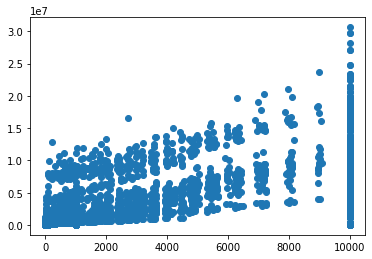

In [6]:
plt.scatter(ohe_data['INPUT_ROWS'],ohe_data['RUNTIME_NS'])

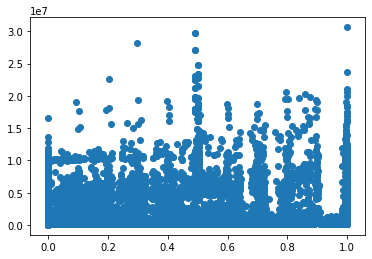

In [7]:
plt.scatter(ohe_data['SELECTIVITY'],ohe_data['RUNTIME_NS'])
#plt.ylim(0, 100000)

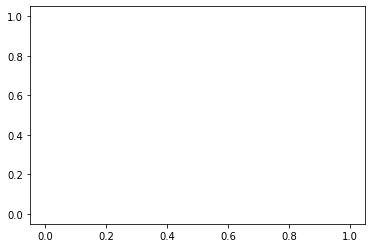

In [8]:
weird_data = ohe_data.loc[(ohe_data['RUNTIME_NS'] < 100000) & (ohe_data['SELECTIVITY'] > 0) ]
weird_data.head()
plt.scatter(weird_data['SELECTIVITY'],weird_data['RUNTIME_NS'])

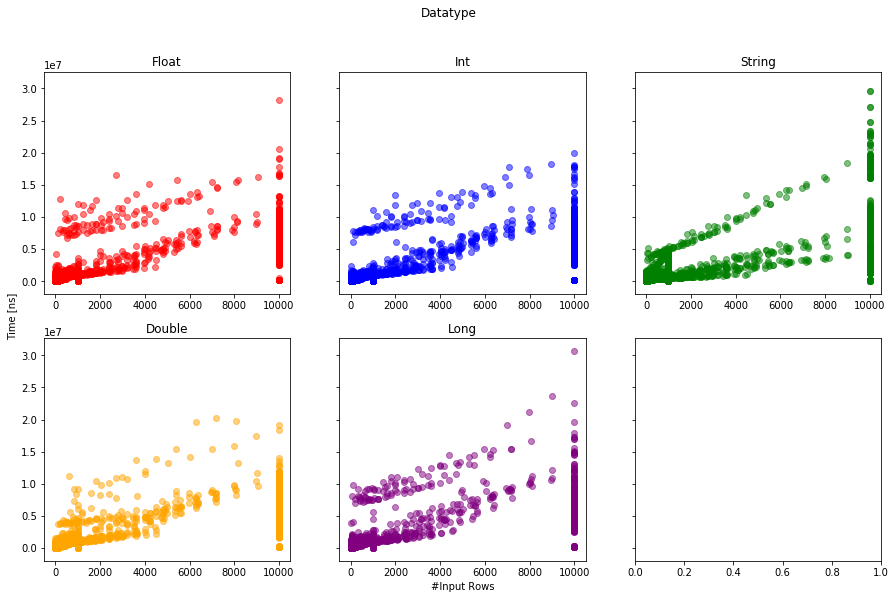

In [9]:
# looking at impact of the datatype

floats = ohe_data.loc[ohe_data['DATA_TYPE_float'] == 1]
ints = ohe_data.loc[ohe_data['DATA_TYPE_int'] == 1]
strings = ohe_data.loc[ohe_data['DATA_TYPE_string'] == 1]
longs = ohe_data.loc[ohe_data['DATA_TYPE_long'] == 1]
doubles = ohe_data.loc[ohe_data['DATA_TYPE_double'] == 1]

fig, axs = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(15,9))
fig.suptitle('Datatype')
axs[0,0].scatter(floats['INPUT_ROWS'], floats['RUNTIME_NS'], color='r', alpha=0.5)
axs[0, 0].set_title('Float')
axs[0,1].scatter(ints['INPUT_ROWS'], ints['RUNTIME_NS'], color='b', alpha=0.5)
axs[0, 1].set_title('Int')
axs[0,2].scatter(strings['INPUT_ROWS'], strings['RUNTIME_NS'], color='g', alpha=0.5)
axs[0, 2].set_title('String')
axs[1,0].scatter(doubles['INPUT_ROWS'], doubles['RUNTIME_NS'], color='orange',alpha=0.5)
axs[1,0].set_title('Double')
axs[1,1].scatter(longs['INPUT_ROWS'], longs['RUNTIME_NS'], color='purple', alpha=0.5)
axs[1,1].set_title('Long')

# for labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("#Input Rows")
plt.ylabel("Time [ns]")
plt.show()

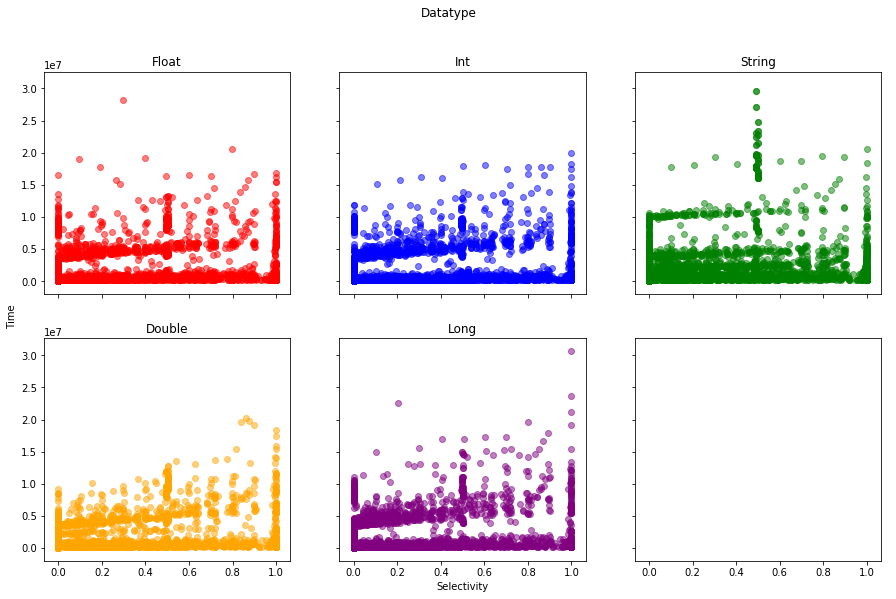

In [10]:
# looking at impact of the datatype

floats = ohe_data.loc[ohe_data['DATA_TYPE_float'] == 1]
ints = ohe_data.loc[ohe_data['DATA_TYPE_int'] == 1]
strings = ohe_data.loc[ohe_data['DATA_TYPE_string'] == 1]
longs = ohe_data.loc[ohe_data['DATA_TYPE_long'] == 1]
doubles = ohe_data.loc[ohe_data['DATA_TYPE_double'] == 1]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,9))
fig.suptitle('Datatype')
axs[0,0].scatter(floats['SELECTIVITY'], floats['RUNTIME_NS'], color='r', alpha=0.5)
axs[0, 0].set_title('Float')
axs[0,1].scatter(ints['SELECTIVITY'], ints['RUNTIME_NS'], color='b', alpha=0.5)
axs[0, 1].set_title('Int')
axs[0,2].scatter(strings['SELECTIVITY'], strings['RUNTIME_NS'], color='g', alpha=0.5)
axs[0, 2].set_title('String')
axs[1,0].scatter(doubles['SELECTIVITY'], doubles['RUNTIME_NS'], color='orange',alpha=0.5)
axs[1,0].set_title('Double')
axs[1,1].scatter(longs['SELECTIVITY'], longs['RUNTIME_NS'], color='purple', alpha=0.5)
axs[1,1].set_title('Long')
#axs[0,0].set_ylim([0, 100000])
# for labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Selectivity")
plt.ylabel("Time")
plt.show()

In [11]:
# looks like strings can take way longer than the other datatypes

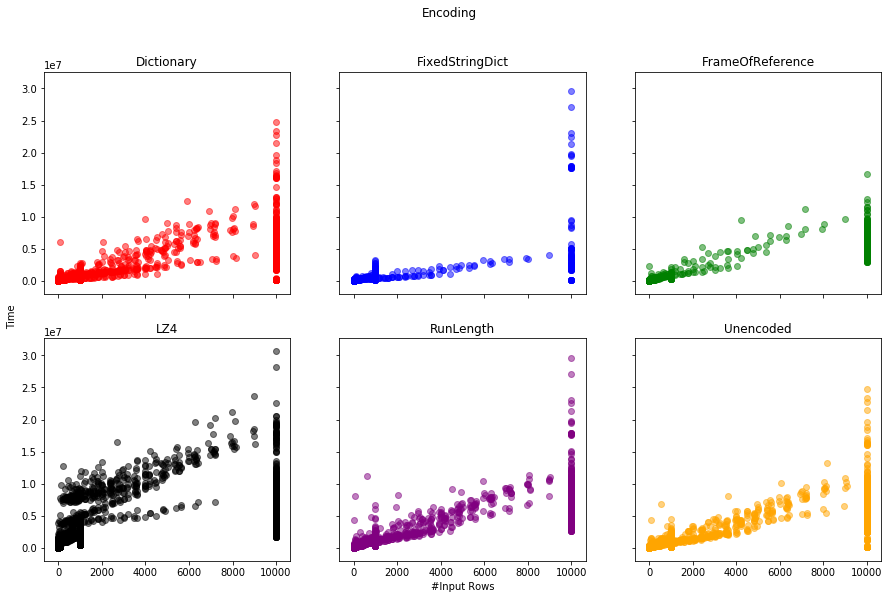

In [12]:
# looking at impact of the datatype

dicts = ohe_data.loc[ohe_data['ENCODING_Dictionary'] == 1]
fsdicts = ohe_data.loc[ohe_data['ENCODING_FixedStringDictionary'] == 1]
forefs = ohe_data.loc[ohe_data['ENCODING_FrameOfReference'] == 1]
lz4s = ohe_data.loc[ohe_data['ENCODING_LZ4'] == 1]
runls = ohe_data.loc[ohe_data['ENCODING_RunLength'] == 1]
noencs = ohe_data.loc[ohe_data['ENCODING_Unencoded'] == 1]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,9))
#ax=fig.add_axes([0,0,1,1])
fig.suptitle('Encoding')
axs[0,0].scatter(dicts['INPUT_ROWS'], dicts['RUNTIME_NS'], color='r', alpha=0.5)
axs[0, 0].set_title('Dictionary')
axs[0,1].scatter(fsdicts['INPUT_ROWS'], fsdicts['RUNTIME_NS'], color='b', alpha=0.5)
axs[0, 1].set_title('FixedStringDict')
axs[0,2].scatter(forefs['INPUT_ROWS'], forefs['RUNTIME_NS'], color='g', alpha=0.5)
axs[0, 2].set_title('FrameOfReference')
axs[1,0].scatter(lz4s['INPUT_ROWS'], lz4s['RUNTIME_NS'], color='black',alpha=0.5)
axs[1, 0].set_title('LZ4')
axs[1,1].scatter(runls['INPUT_ROWS'], runls['RUNTIME_NS'], color='purple', alpha=0.5)
axs[1, 1].set_title('RunLength')
axs[1,2].scatter(noencs['INPUT_ROWS'], noencs['RUNTIME_NS'], color='orange',alpha=0.5)
axs[1, 2].set_title('Unencoded')

# for labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("#Input Rows")
plt.ylabel("Time")
    
plt.show()


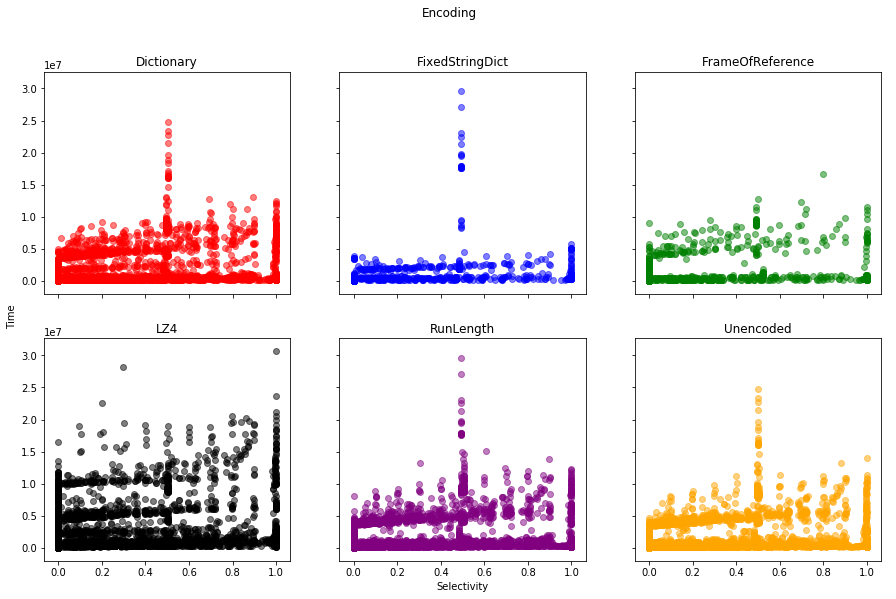

In [13]:
# looking at impact of the datatype

dicts = ohe_data.loc[ohe_data['ENCODING_Dictionary'] == 1]
fsdicts = ohe_data.loc[ohe_data['ENCODING_FixedStringDictionary'] == 1]
forefs = ohe_data.loc[ohe_data['ENCODING_FrameOfReference'] == 1]
lz4s = ohe_data.loc[ohe_data['ENCODING_LZ4'] == 1]
runls = ohe_data.loc[ohe_data['ENCODING_RunLength'] == 1]
noencs = ohe_data.loc[ohe_data['ENCODING_Unencoded'] == 1]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,9))
#ax=fig.add_axes([0,0,1,1])
fig.suptitle('Encoding')
axs[0,0].scatter(dicts['SELECTIVITY'], dicts['RUNTIME_NS'], color='r', alpha=0.5)
axs[0, 0].set_title('Dictionary')
axs[0,1].scatter(fsdicts['SELECTIVITY'], fsdicts['RUNTIME_NS'], color='b', alpha=0.5)
axs[0, 1].set_title('FixedStringDict')
axs[0,2].scatter(forefs['SELECTIVITY'], forefs['RUNTIME_NS'], color='g', alpha=0.5)
axs[0, 2].set_title('FrameOfReference')
axs[1,0].scatter(lz4s['SELECTIVITY'], lz4s['RUNTIME_NS'], color='black',alpha=0.5)
axs[1, 0].set_title('LZ4')
axs[1,1].scatter(runls['SELECTIVITY'], runls['RUNTIME_NS'], color='purple', alpha=0.5)
axs[1, 1].set_title('RunLength')
axs[1,2].scatter(noencs['SELECTIVITY'], noencs['RUNTIME_NS'], color='orange',alpha=0.5)
axs[1, 2].set_title('Unencoded')
#axs[0,0].set_ylim([0, 100000])

# for labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Selectivity")
plt.ylabel("Time")
    
plt.show()
